In [20]:
#######################
# 1. Install & Import Required Libraries
#######################
!pip install category_encoders optuna xgboost scikit-learn pandas matplotlib seaborn gitpython

import os
import git
import zipfile
import optuna
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from imblearn.combine import SMOTETomek
from category_encoders import TargetEncoder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.0 MB/s eta 0:00:00


In [2]:
#######################
# 2. Clone GitHub Repository
#######################
repo_url = "https://github.com/McGill-MMA-EnterpriseAnalytics/Fraud-Detection.git"
repo_path = "/content/Fraud-Detection"
!git clone $repo_url $repo_path


Cloning into '/content/Fraud-Detection'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (51/51), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 107 (delta 31), reused 21 (delta 18), pack-reused 56 (from 1)
Receiving objects: 100% (107/107), 78.73 MiB | 21.58 MiB/s, done.
Resolving deltas: 100% (35/35), done.


In [3]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [4]:
#######################
# 3. Extract Preprocessing Files
#######################
!unrar x /content/Fraud-Detection/data/processed_dataset.rar /content/Fraud-Detection/data/



UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/Fraud-Detection/data/processed_dataset.rar


Would you like to replace the existing file /content/Fraud-Detection/data/content/processed_test_set.csv
5451326 bytes, modified on 2025-02-26 18:21
with a new one
5451326 bytes, modified on 2025-02-26 18:21

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Q

Program aborted


In [25]:
#######################
# 4. Load Train & Test Data
#######################

train_df = pd.read_csv("/content/Fraud-Detection/data/content/processed_train_set.csv")
test_df = pd.read_csv("/content/Fraud-Detection/data/content/processed_test_set.csv")

In [19]:
train_df.head()

,Age,State,City,Transaction_Amount,Merchant_Category,Account_Balance,Transaction_Location,Device_Type,Is_Fraud,Transaction_Description,...,Account_Type_Checking,Account_Type_Savings,Transaction_Type_Online,Transaction_Type_POS,Transaction_Device_Mobile,Transaction_Device_POS Terminal,Transaction_Device_Web,Time_Category_Evening,Time_Category_Morning,Time_Category_Night
0,55,6,3,82.117696,4,5967.793219,5,2,0,4,...,False,False,False,True,False,False,True,False,False,False
1,59,2,1,74.399478,5,2539.502154,3,2,0,3,...,False,True,False,True,False,False,False,False,True,False
2,63,2,3,74.908080,0,4239.124607,3,2,0,2,...,False,True,True,False,False,False,False,False,False,False
3,48,0,1,540.199955,3,4981.358229,6,0,1,3,...,False,True,True,False,False,False,False,True,False,False
4,23,5,5,79.173752,0,6824.554127,1,2,0,2,...,False,True,False,False,False,True,False,True,False,False


In [26]:
#######################
# 2. Remove Transaction_Location from the Dataset (Data Leakage Prevention)
#######################
train_df = train_df.drop(columns=["Transaction_Location", "Transaction_Amount"], errors='ignore')
test_df = test_df.drop(columns=["Transaction_Location", "Transaction_Amount"], errors='ignore')

In [27]:
#######################
# 3. Apply Target Encoding to Merchant_Category
#######################

encoder = TargetEncoder(cols=["Merchant_Category"])
train_df["Merchant_Category"] = encoder.fit_transform(train_df["Merchant_Category"], train_df["Is_Fraud"])
test_df["Merchant_Category"] = encoder.transform(test_df["Merchant_Category"])

In [28]:
#######################
# 3. Prepare Features & Target
#######################
X = train_df.drop(columns=["Is_Fraud"])
y = train_df["Is_Fraud"]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Ensure test set features and labels are correctly extracted
X_test = test_df.drop(columns=["Is_Fraud"], errors='ignore')
y_test = test_df["Is_Fraud"] if "Is_Fraud" in test_df.columns else None


In [29]:
#######################
# 5. Define Optuna Objective Function for Hyperparameter Tuning
#######################
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 5.0, 20.0, log=True),
        "alpha": trial.suggest_float("alpha", 5.0, 20.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 5),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 500),
        "min_child_weight": trial.suggest_int("min_child_weight", 10, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }

    model = xgb.XGBClassifier(**params, use_label_encoder=False, verbosity=0)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc').mean()
    return score


In [30]:
#######################
# 6. Run Optuna Optimization
#######################
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

print("Best Hyperparameters:", study.best_params)


[I 2025-02-26 20:34:45,838] A new study created in memory with name: no-name-0ee82c02-8ee8-4b45-8463-6376f36fca2c
[I 2025-02-26 20:34:51,605] Trial 0 finished with value: 0.9999746858798962 and parameters: {'lambda': 9.737864142784929, 'alpha': 11.066167578923855, 'max_depth': 4, 'learning_rate': 0.060606628144007496, 'n_estimators': 304, 'min_child_weight': 13, 'subsample': 0.6724126195164526, 'colsample_bytree': 0.7040738934109703}. Best is trial 0 with value: 0.9999746858798962.
[I 2025-02-26 20:34:56,947] Trial 1 finished with value: 0.987058343608991 and parameters: {'lambda': 18.643966858433913, 'alpha': 14.581177100714612, 'max_depth': 3, 'learning_rate': 0.025819273590187434, 'n_estimators': 182, 'min_child_weight': 20, 'subsample': 0.7500753329365386, 'colsample_bytree': 0.9896358804565084}. Best is trial 0 with value: 0.9999746858798962.
[I 2025-02-26 20:35:01,447] Trial 2 finished with value: 0.9997466290967623 and parameters: {'lambda': 6.542516925459357, 'alpha': 10.200759

Best Hyperparameters: {'lambda': 11.552918430516232, 'alpha': 6.377279950730096, 'max_depth': 5, 'learning_rate': 0.28901944369301596, 'n_estimators': 260, 'min_child_weight': 15, 'subsample': 0.9732543725514585, 'colsample_bytree': 0.9184564157773536}


In [31]:
#######################
# 7. Train Final XGBoost Model with Best Parameters
#######################
best_params = {
    "lambda": 18.035420264774213,
    "alpha": 6.134039170033844,
    "max_depth": 2,
    "learning_rate": 0.01405371208315621,
    "n_estimators": 431,
    "min_child_weight": 17,
    "subsample": 0.56404781868734,
    "colsample_bytree": 0.8738544807326076
}

final_model = xgb.XGBClassifier(**best_params, use_label_encoder=False, verbosity=0)
final_model.fit(X_train, y_train)


XGBClassifier(alpha=6.134039170033844, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8738544807326076, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=18.035420264774213,
              learning_rate=0.01405371208315621, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=17, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=431, n_jobs=None, ...)

ROC AUC Score: 0.9867581275201613
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     29760
           1       0.74      0.53      0.62      2240

    accuracy                           0.95     32000
   macro avg       0.86      0.76      0.80     32000
weighted avg       0.95      0.95      0.95     32000



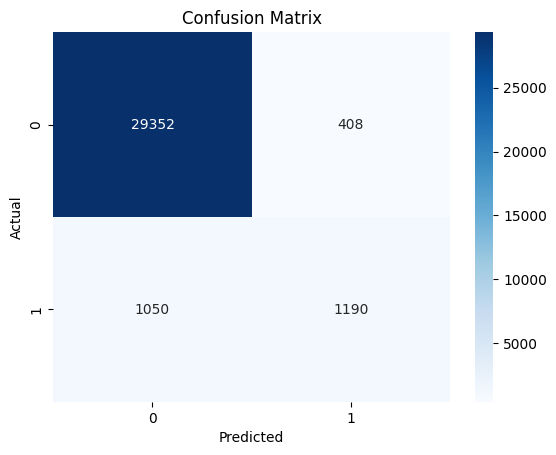

In [32]:
#######################
# 8. Model Evaluation
#######################
y_pred = final_model.predict(X_valid)
y_prob = final_model.predict_proba(X_valid)[:, 1]

print("ROC AUC Score:", roc_auc_score(y_valid, y_prob))
print("Classification Report:\n", classification_report(y_valid, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_valid, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


ROC AUC Score (Test): 0.9869806067588326
Classification Report (Test):
               precision    recall  f1-score   support

           0       0.96      0.99      0.97     37200
           1       0.74      0.49      0.59      2800

    accuracy                           0.95     40000
   macro avg       0.85      0.74      0.78     40000
weighted avg       0.95      0.95      0.95     40000



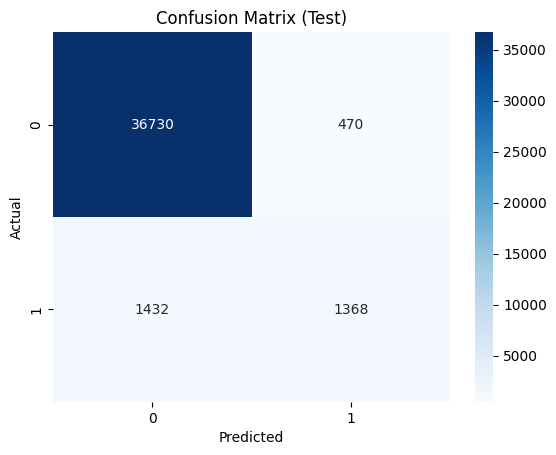

In [33]:
#######################
# 8. Predictions and Evaluation on Test Set
#######################
y_test_pred = final_model.predict(X_test)
y_test_prob = final_model.predict_proba(X_test)[:, 1]

print("ROC AUC Score (Test):", roc_auc_score(y_test, y_test_prob))
print("Classification Report (Test):\n", classification_report(y_test, y_test_pred))

# Confusion Matrix for Test Set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test)')
plt.show()

In [34]:
importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': final_model.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df.head(10))


                            Feature  Importance
3                 Merchant_Category    0.262213
7                   Transaction_Day    0.242981
5                       Device_Type    0.184776
17        Transaction_Device_Mobile    0.158396
18  Transaction_Device_POS Terminal    0.151633
0                               Age    0.000000
13            Account_Type_Checking    0.000000
21            Time_Category_Morning    0.000000
20            Time_Category_Evening    0.000000
19           Transaction_Device_Web    0.000000


In [38]:
import joblib

# Save the trained XGBoost model in the current directory
model_filename = "xgboost_fraud_model.pkl"
joblib.dump(final_model, model_filename)

print(f"Trained model saved as: {model_filename}")


Trained model saved as: xgboost_fraud_model.pkl
